In [1]:
import numpy as np
from scipy.interpolate import LSQBivariateSpline, bisplrep, bisplev

import matplotlib.pyplot as plt
from astropy.modeling import models
import astropy.units as u
from astropy.io import fits
from astropy.visualization import (ZScaleInterval, SqrtStretch, ImageNormalize)

from specreduce.utils.synth_data import make_2d_arc_image

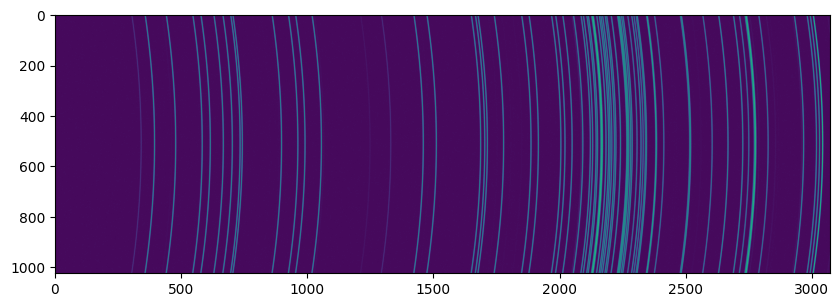

In [2]:
model_deg2 = models.Legendre1D(degree=2, c0=50, c1=0, c2=100)
im = make_2d_arc_image(
    nx=3072,
    ny=1024,
    linelists=['HeI', 'ArI'],
    line_fwhm=3,
    tilt_func=model_deg2,
    amplitude_scale=0.1,
    background=100
)
fig = plt.figure(figsize=(10, 6))
plt.imshow(im.data)

In [5]:
y, x = np.indices(im.shape)
ysize, xsize = im.shape
noise = np.sqrt(im)
weights = 1 / noise
xknots = np.linspace(0, xsize, int(xsize))
yknots = np.linspace(0, ysize, int(ysize/50))
x_rect = x.ravel() + model_deg2(y.ravel() - ysize/2)/ysize
spline_fit = LSQBivariateSpline(
    x_rect, y.ravel(), im.data.ravel(), xknots, yknots, w=weights.ravel(), kx=1, ky=3
)

/Users/tim/conda/envs/specreduce/lib/python3.12/site-packages/scipy/interpolate/_fitpack2.py:1519: UserWarning: 
The coefficients of the spline returned have been computed as the
minimal norm least-squares solution of a (numerically) rank deficient
system (deficiency=50780). If deficiency is large, the results may be
inaccurate. Deficiency may strongly depend on the value of eps.
  warnings.warn(message)


In [8]:
fig = plt.figure(figsize=(10, 6))
yinterp = np.arange(0, ysize)
xinterp = np.arange(0, xsize) + model_deg2(yinterp - ysize/2)/ysize
zinterp = np.transpose(spline_fit(xinterp, yinterp))
norm = ImageNormalize(im.data - zinterp, interval=ZScaleInterval(contrast=0.0005), stretch=SqrtStretch())
plt.imshow(im.data - zinterp, cmap='gray', norm=norm)

ValueError: operands could not be broadcast together with shapes (3072,) (1024,) 

<Figure size 1000x600 with 0 Axes>

In [7]:
fits.writeto("blah.fits", im.data-zinterp, overwrite=True)

In [119]:
fits.writeto("interp.fits", zinterp, overwrite=True)